## 機械学習の精度を上げる（特徴量エンジニアリング）

## 目次

 - この章の目的
 
 - 処理を関数化
 
 - 仮説検証① - PassengerIdを除く
 
 - 仮説検証② - FamilySize列を作成
 
 - 仮説検証③ - Parch, SibSpが0の人のフラグを立てる
 
 - 仮説検証④ - 0-10歳は生存者が多いかも
 
 - おわりに

## この章の目的

この章の目的は、「**機械学習の精度を上げる**」です。

前の章から導かれた仮説が

 - PassengerIdを除くとよいかも

 - FamilySizeを入れるとよいかも

 - Parch, SibSpが0の人はSurvive率が低いかも

 - 0-10歳は生存者が多いかも

の4つでした。今回はこの仮説を試してみます。

その前に、ソースコードを関数化によってリファクタリングします。

## 処理を関数化

今回の場合は処理があまり大きくないため、

 - トレーニングデータとテストデータの前処理用の関数
 - トレーニングデータの評価用の関数
 - テストデータ予測用の関数
 - 特徴量の重要度を出力

の４つを関数化します。

リファクタリング後のソースコードが以下。

 - ソースコード


0.8103254769921436


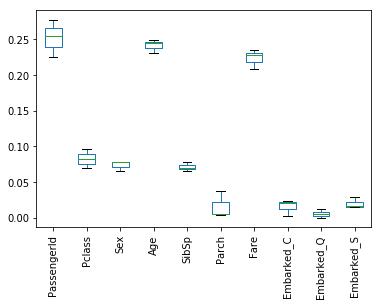

In [3]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pylab as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')


def validate(train_x, train_y):
    accuracies = []
    feature_importances = []

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    for train_idx, test_idx in cv.split(train_x, train_y):
        trn_x = train_x.iloc[train_idx, :]
        val_x = train_x.iloc[test_idx, :]

        trn_y = train_y.iloc[train_idx]
        val_y = train_y.iloc[test_idx]

        clf = xgb.XGBClassifier()
        clf.fit(trn_x, trn_y)

        pred_y = clf.predict(val_x)
        feature_importances.append(clf.feature_importances_)
        accuracies.append(accuracy_score(val_y, pred_y))
    print(np.mean(accuracies))
    return accuracies, feature_importances


def plot_feature_importances(feature_importances, cols):
    df_fimp = pd.DataFrame(feature_importances, columns=cols)
    df_fimp.plot(kind="box", rot=90)


def preprocess_df(df):
    # CabinはこのあとDropするので、コードから削除
    df["Age"] = df["Age"].fillna(df["Age"].mean())
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode())
    
    # 列の削除
    df.drop(["Name", "Ticket", "Cabin"], axis=1, inplace=True)
    
    # Sexの01化とEmbarkedのダミー化 
    df["Sex"] = df["Sex"].replace({"male": 0, "female": 1})
    df = pd.get_dummies(df)

    return df


# test dataのpredict
def predict_df(train_x, train_y, test_x, df_test_raw, path_output="result.csv"):
    clf = xgb.XGBClassifier()
    clf.fit(train_x, train_y)
    preds = clf.predict(test_x)
    
    _df = pd.DataFrame()
    _df["PassengerId"] = df_test_raw["PassengerId"]
    _df["Survived"] = preds
    _df.to_csv(path_output, index=False)


# デバッグするときはmain関数から外して、直で叩く方が楽です。
def main():
    df_train = pd.read_csv("train.csv")

    # ここは前処理
    train_y = df_train["Survived"]
    train_x = df_train.drop("Survived", axis=1)

    train_x = preprocess_df(train_x)
    accuracies, feature_importances = validate(train_x, train_y)
    plot_feature_importances(feature_importances, train_x.columns)

    flag_product = True
    if flag_product:
        df_test = pd.read_csv("test.csv")
        df_test_raw = df_test.copy()
        test_x = preprocess_df(df_test)
        predict_df(train_x, train_y, test_x, df_test_raw, "result.csv")


#  `if __name__ == '__main__':` はおまじないのようなモノと思ってください。
if __name__ == '__main__':
    main()


リファクタリングしただけなので、前と同じ精度が出ていればOKです。

plotの部分は面倒くさかったらけしてください。

## 仮説検証① - PassengerIdを除く

まずは、PassengerIdを除きます。

列を除くには `df.drop(列名, axis=1, inplace=True)` でOKでしたね。

 - ソースコード


0.8226711560044894


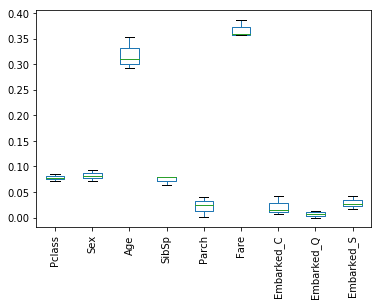

In [4]:
def preprocess_df(df):
    # CabinはこのあとDropするので、コードから削除
    df["Age"] = df["Age"].fillna(df["Age"].mean())
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode())
    
    # 列の削除
    df.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis=1, inplace=True)
    
    # Sexの01化とEmbarkedのダミー化 
    df["Sex"] = df["Sex"].replace({"male": 0, "female": 1})
    df = pd.get_dummies(df)

    return df

if __name__ == '__main__':
    main()

CVの値が上がること、実際にKaggleにSubmitすると精度が上がっていることが確認できると思います。

## 仮説検証② - FamilySize列を作成

次に、SibSpとParchの数を足して、FamilySizeという列を作ってみます。

`preprocess_df` 関数の中身だけ書き換えればOKなので、そこだけ反映しています。

 - ソースコード


0.8237934904601572


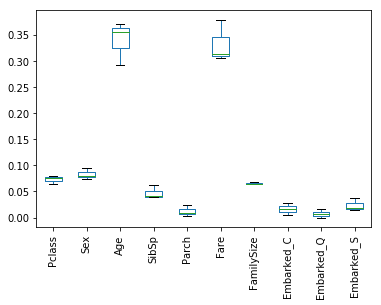

In [5]:
def preprocess_df(df):
    # CabinはこのあとDropするので、コードから削除
    df["Age"] = df["Age"].fillna(df["Age"].mean())
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode())
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
   
    # 列の削除
    df.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis=1, inplace=True)
    
    # Sexの01化とEmbarkedのダミー化 
    df["Sex"] = df["Sex"].replace({"male": 0, "female": 1})
    df = pd.get_dummies(df)

    return df

if __name__ == '__main__':
    main()

cvの平均値が上がること、FamilySizeがそれなりの重要度を持っていることがわかると思います。

このように、単純な変数も以外と予測には効くことが多いです。

## 仮説検証③ - Parch, SibSpが0の人のフラグを立てる

Parch, SibSpが0の人のフラグを立てます。

先程FamilySizeという変数も作ったので、こちらの値が1の人も別途フラグを立ててみましょう。

 - ソースコード


0.8237934904601572


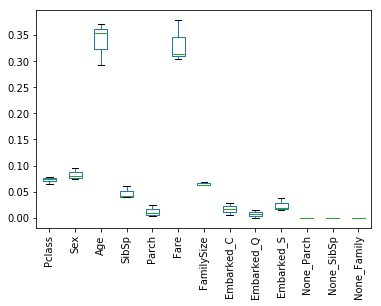

In [6]:
def preprocess_df(df):
    # CabinはこのあとDropするので、コードから削除
    df["Age"] = df["Age"].fillna(df["Age"].mean())
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode())
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
   
    # 列の削除
    df.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis=1, inplace=True)

    # Sexの01化とEmbarkedのダミー化 
    df["Sex"] = df["Sex"].replace({"male": 0, "female": 1})
    df = pd.get_dummies(df)
    
    # Parch, SibSp, FamilySize関連のFlag
    df["None_Parch"] = [1 if val == 0 else 0 for val in df["Parch"]]
    df["None_SibSp"] = [1 if val == 0 else 0 for val in df["SibSp"]]
    df["None_Family"] = [1 if val == 1 else 0 for val in df["FamilySize"]]

    return df

if __name__ == '__main__':
    main()

accuracyの値が変わっていないこと、特徴量の重要度としても0であり全く使われていないことがわかります。

今回はこれらは特徴量に入れなくてよさそうです。

`[1 if val == 0 else 0 for val in df[列名]]`の部分は[1章](01_Python入門)で学習した、リスト内包表記を使用しています。

次に、0〜10歳についても検証してみます。

## 仮説検証④ - 0-10歳は生存者が多いかも

 - ソースコード


0.8237934904601572


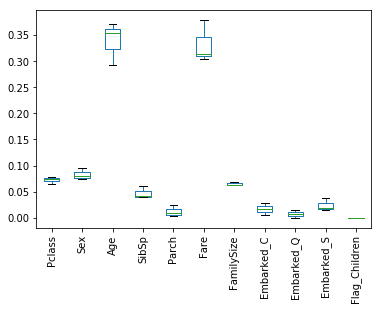

In [7]:
def preprocess_df(df):
    # CabinはこのあとDropするので、コードから削除
    df["Age"] = df["Age"].fillna(df["Age"].mean())
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode())
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
   
    # 列の削除
    df.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis=1, inplace=True)

    # Sexの01化とEmbarkedのダミー化 
    df["Sex"] = df["Sex"].replace({"male": 0, "female": 1})
    df = pd.get_dummies(df)
    
    # Parch, SibSp, FamilySize関連のFlag
    df["Flag_Children"] = [1 if val < 11 else 0 for val in df["Age"]]

    return df

if __name__ == '__main__':
    main()

accuracyの値が変わっていないこと、特徴量の重要度としても0であり全く使われていないことがわかります。

今回はこれも特徴量に入れなくてよさそうです。

## おわりに

ここでは以下の仮説を検証しました。

 - PassengerIdを除くとよいかも <br>
     → 採用

 - FamilySizeを入れるとよいかも <br>
     → 採用

 - Parch, SibSpが0の人はSurvive率が低いかも <br>
     → 非採用

 - 0-10歳は生存者が多いかも <br>
     → 非採用

実際のところ、採用できる仮説はほとんどないです。

また、クロスバリデーションで評価した値と実際のスコアは一致するとは限らないので、注意してください。

（実際、FamilySizeを入れて計算した値をSubmitすると少しスコアが下がります。 <br>
今回はチュートリアルなので、クロスバリデーションの値が上がったら採用としています。）

次回は、機械学習のハイパーパラメーターのチューニングによりスコアをあげてみます。
